In [1]:
#Importing required packages
import pandas as pd 
import numpy as np 
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn import ensemble,linear_model,neighbors,metrics,tree
import xgboost
import pickle
import pandas_profiling 
import warnings
warnings.filterwarnings("ignore")
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/tmp/ipykernel_20/3784856478.py:16: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profilin

In [2]:
#Importing data:
train = pd.read_csv("/kaggle/input/walmart-sales-forecast/train.csv")
test = pd.read_csv('/kaggle/input/walmart-sales-forecast/test.csv')
stores = pd.read_csv('/kaggle/input/walmart-sales-forecast/stores.csv')
feature=pd.read_csv('/kaggle/input/walmart-sales-forecast/features.csv')

In [3]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
stores.Store.nunique()

45

In [5]:
feature.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [6]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
train.Dept.nunique()

81

In [8]:
test.tail()

,Store,Dept,Date,IsHoliday
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False
115063,45,98,2013-07-26,False


In [9]:
test.Dept.nunique()

81

In [10]:
train_bt = pd.merge(train,stores) 
train = pd.merge(train_bt,feature)
#
test_bt = pd.merge(test,stores)
test= pd.merge(test_bt,feature)

In [11]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [12]:
test.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
2,1,3,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
3,1,4,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
4,1,5,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573


In [13]:
print(train.info())
print("---------------------------------------------------")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB
None
-------------------

### 1. Training Data

In [14]:
numeric_var_train=[key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_train=[key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['object']]
# Train Numerical Data
train_num=train[numeric_var_train]

# Train Categorical Data
train_cat=train[cat_var_train]
print(numeric_var_train)
print(cat_var_train)

['Store', 'Dept', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
['Date', 'Type']


### 2. Testing Data

In [15]:
numeric_var_test=[key for key in dict(test.dtypes) if dict(test.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_test=[key for key in dict(test.dtypes) if dict(test.dtypes)[key] in ['object']]
# Train Numerical Data
test_num=test[numeric_var_test]

# Train Categorical Data
test_cat=test[cat_var_test]
print(numeric_var_test)
print(cat_var_test)

['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
['Date', 'Type']


In [16]:
Profile_train=pandas_profiling.ProfileReport(train)
Profile_train.to_file('data_profile_output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
train_corr=pd.DataFrame(train.corr())
train_corr.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000000,0.024004,-0.085195,-0.000548,-0.182881,-0.050097,0.065290,-0.119588,-0.035173,-0.031556,-0.009941,-0.026634,-0.211088,0.208552
Dept,0.024004,1.000000,0.148032,0.000916,-0.002966,0.004437,0.003572,-0.002426,0.000290,0.001784,0.004257,0.000109,-0.007477,0.007837
Weekly_Sales,-0.085195,0.148032,1.000000,0.012774,0.243828,-0.002312,-0.000120,0.085251,0.024130,0.060385,0.045414,0.090362,-0.020921,-0.025864
IsHoliday,-0.000548,0.000916,0.012774,1.000000,0.000593,-0.155949,-0.078281,-0.035586,0.334818,0.427960,-0.000562,-0.053719,-0.001944,0.010460
Size,-0.182881,-0.002966,0.243828,0.000593,1.000000,-0.058313,0.003361,0.345673,0.108827,0.048913,0.168196,0.304575,-0.003314,-0.068238


<Axes: >

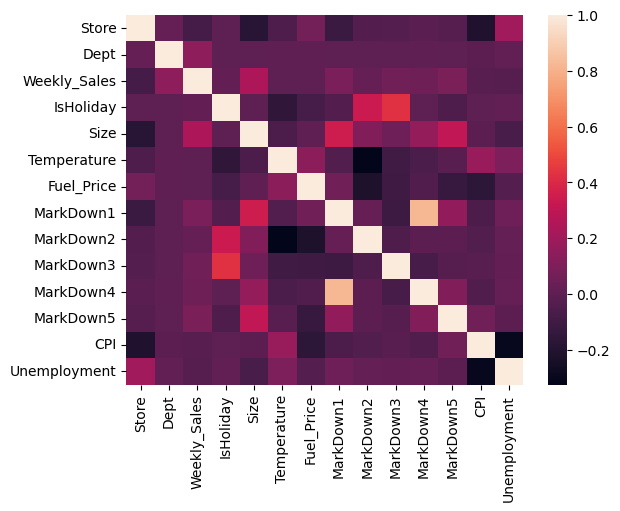

In [18]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(train.corr())

<Axes: >

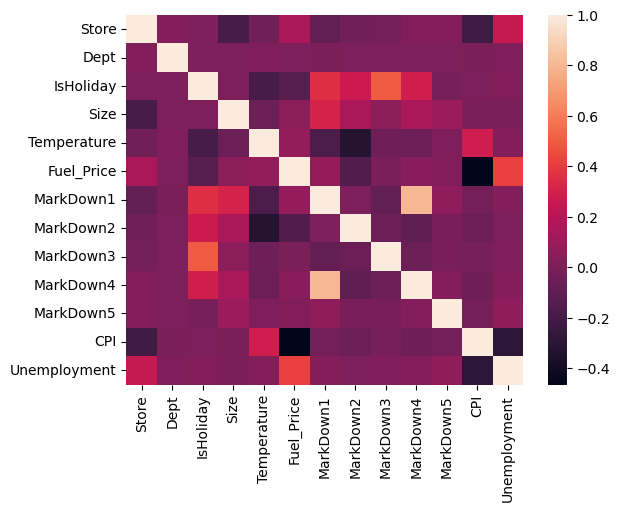

In [19]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(test.corr())

#### Data Exploratory Analysis

<Axes: >

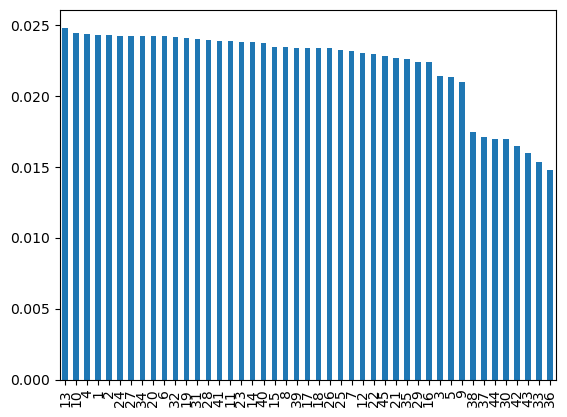

In [20]:
train['Store'].value_counts(normalize=True).plot(kind = 'bar',fig=(4,5))

In [21]:
train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


<Axes: >

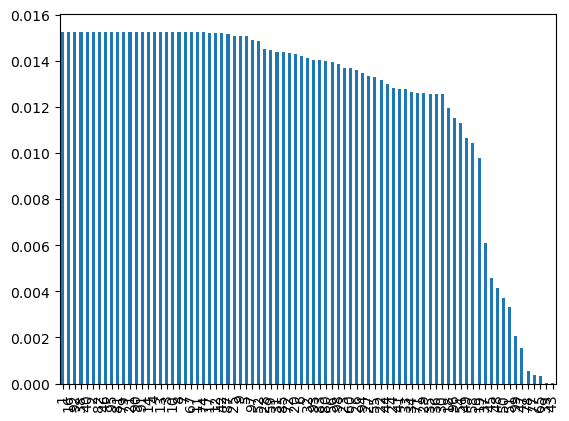

In [22]:
train.Dept.value_counts(normalize=True).plot(kind = 'bar',fig=(4,5))

<Axes: xlabel='Weekly_Sales', ylabel='Density'>

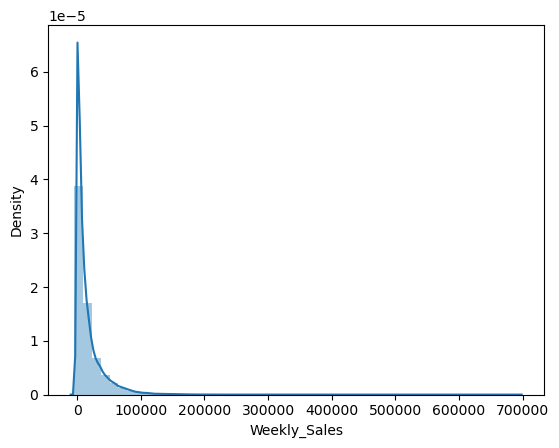

In [23]:
sns.distplot(train.Weekly_Sales)

#### Store Size vs Sales

<Axes: xlabel='Weekly_Sales'>

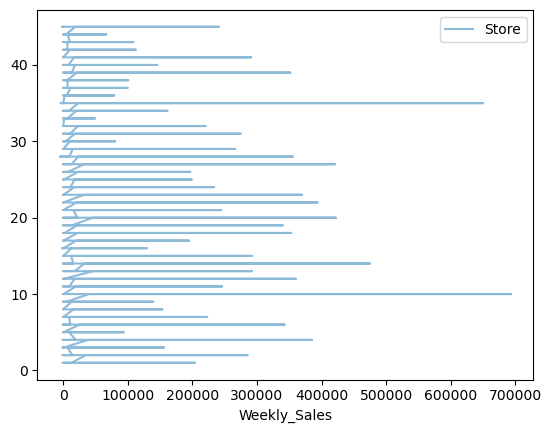

In [24]:
train.plot(kind='line', x='Weekly_Sales', y='Store', alpha=0.5)

#### Sales vs Type

<Axes: xlabel='Weekly_Sales', ylabel='Type'>

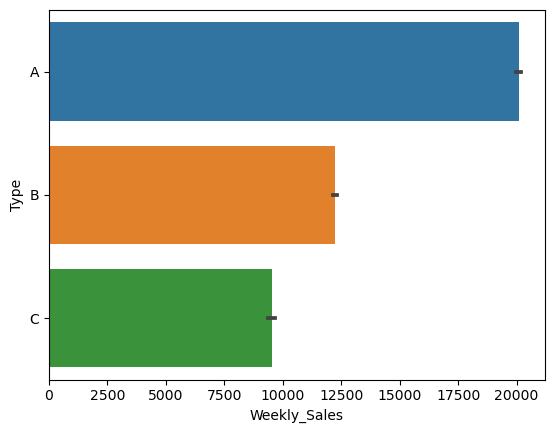

In [25]:
sns.barplot(x=train["Weekly_Sales"],y=train["Type"])

### Missing values treatments

In [26]:
print(train.isnull().sum())
print("_"*30)
print(test.isnull().sum())

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64
______________________________
Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
dtype: int64


In [27]:
test.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
2,1,3,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
3,1,4,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
4,1,5,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573


In [28]:
test['CPI']=test.groupby(['Dept'])['CPI'].transform(lambda x: x.fillna(x.median()))
test['Unemployment']=test.groupby(['Dept'])['Unemployment'].transform(lambda x: x.fillna(x.median()))

<Axes: >

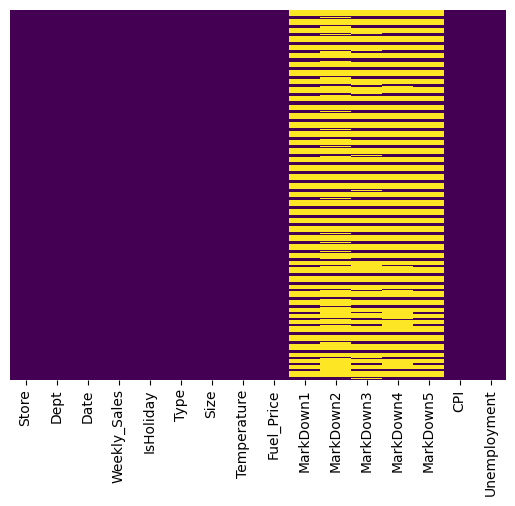

In [29]:
sns.heatmap(train.isnull(),yticklabels= False,cbar=False, cmap='viridis')

In [30]:
train=train.fillna(0)
test=test.fillna(0)

In [31]:
print(train.isnull().sum())
print("_"*30)
print(test.isnull().sum())

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64
______________________________
Store           0
Dept            0
Date            0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     421570 non-null  float64
 10  MarkDown2     421570 non-null  float64
 11  MarkDown3     421570 non-null  float64
 12  MarkDown4     421570 non-null  float64
 13  MarkDown5     421570 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 68.0+ MB


### Outlier Treatment

In [33]:
# we can find outliers in sales
train.Weekly_Sales=np.where(train.Weekly_Sales>100000, 100000,train.Weekly_Sales)

<Axes: ylabel='Frequency'>

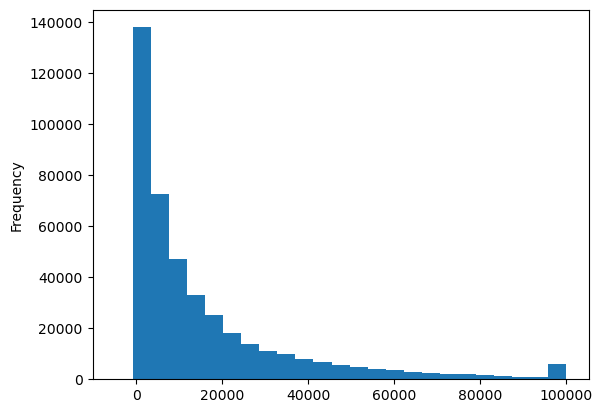

In [34]:
train.Weekly_Sales.plot.hist(bins=25)

### Feature Extraction

In [35]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     421570 non-null  float64       
 10  MarkDown2     421570 non-null  float64       
 11  MarkDown3     421570 non-null  float64       
 12  MarkDown4     421570 non-null  float64       
 13  MarkDown5     421570 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

In [37]:
# Extract date features
train['Date_dayofweek'] =train['Date'].dt.dayofweek
train['Date_month'] =train['Date'].dt.month 
train['Date_year'] =train['Date'].dt.year
train['Date_day'] =train['Date'].dt.day 

test['Date_dayofweek'] =test['Date'].dt.dayofweek
test['Date_month'] =test['Date'].dt.month 
test['Date_year'] =test['Date'].dt.year
test['Date_day'] =test['Date'].dt.day

In [38]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010,5
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010,5
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010,5
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010,5
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010,5


In [39]:
numerical_transformation= Pipeline([
    ('trf1',IterativeImputer(max_iter=100)),
    ('scaler', StandardScaler())
])

categorical_transformation= Pipeline([
    ('trf2', OneHotEncoder(sparse= False))
])

In [40]:
transformation= ColumnTransformer([
    ('num', numerical_transformation, numeric_var_test),
    ('cat', categorical_transformation, ['Type'])
], remainder= 'passthrough',verbose_feature_names_out= False).set_output(transform= 'pandas')

In [41]:
train= transformation.fit_transform(train)
test= transformation.fit_transform(test)

In [42]:
train.head()

,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Type_A,Type_B,Type_C,Date,Weekly_Sales,IsHoliday,Date_dayofweek,Date_month,Date_year,Date_day
0,-1.658199,-1.418742,0.239209,-0.963798,-1.720834,-0.427943,-0.173069,-0.084662,-0.278117,-0.395181,...,1.0,0.0,0.0,2010-02-05,24924.50,False,4,2,2010,5
1,-1.658199,-1.385947,0.239209,-0.963798,-1.720834,-0.427943,-0.173069,-0.084662,-0.278117,-0.395181,...,1.0,0.0,0.0,2010-02-05,50605.27,False,4,2,2010,5
2,-1.658199,-1.353151,0.239209,-0.963798,-1.720834,-0.427943,-0.173069,-0.084662,-0.278117,-0.395181,...,1.0,0.0,0.0,2010-02-05,13740.12,False,4,2,2010,5
3,-1.658199,-1.320356,0.239209,-0.963798,-1.720834,-0.427943,-0.173069,-0.084662,-0.278117,-0.395181,...,1.0,0.0,0.0,2010-02-05,39954.04,False,4,2,2010,5
4,-1.658199,-1.287560,0.239209,-0.963798,-1.720834,-0.427943,-0.173069,-0.084662,-0.278117,-0.395181,...,1.0,0.0,0.0,2010-02-05,32229.38,False,4,2,2010,5


### Feature Selection

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           421570 non-null  float64       
 1   Dept            421570 non-null  float64       
 2   Size            421570 non-null  float64       
 3   Temperature     421570 non-null  float64       
 4   Fuel_Price      421570 non-null  float64       
 5   MarkDown1       421570 non-null  float64       
 6   MarkDown2       421570 non-null  float64       
 7   MarkDown3       421570 non-null  float64       
 8   MarkDown4       421570 non-null  float64       
 9   MarkDown5       421570 non-null  float64       
 10  CPI             421570 non-null  float64       
 11  Unemployment    421570 non-null  float64       
 12  Type_A          421570 non-null  float64       
 13  Type_B          421570 non-null  float64       
 14  Type_C          421570 non-null  flo

In [44]:
# MarkDown5 highly skewed hence removing, also removing "CPI" and "Unemployment"

In [45]:
features_drop=['Unemployment','CPI','MarkDown5']
train=train.drop(features_drop, axis=1)
test=test.drop(features_drop, axis=1)

In [46]:
train.head(2)

,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Type_A,Type_B,Type_C,Date,Weekly_Sales,IsHoliday,Date_dayofweek,Date_month,Date_year,Date_day
0,-1.658199,-1.418742,0.239209,-0.963798,-1.720834,-0.427943,-0.173069,-0.084662,-0.278117,1.0,0.0,0.0,2010-02-05,24924.50,False,4,2,2010,5
1,-1.658199,-1.385947,0.239209,-0.963798,-1.720834,-0.427943,-0.173069,-0.084662,-0.278117,1.0,0.0,0.0,2010-02-05,50605.27,False,4,2,2010,5


In [47]:
test.head(2)

,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Type_A,Type_B,Type_C,Date,IsHoliday,Date_dayofweek,Date_month,Date_year,Date_day
0,-1.657956,-1.413724,0.242483,0.073606,-0.816679,-0.085347,0.316895,-0.16285,0.091459,1.0,0.0,0.0,2012-11-02,False,4,11,2012,2
1,-1.657956,-1.381105,0.242483,0.073606,-0.816679,-0.085347,0.316895,-0.16285,0.091459,1.0,0.0,0.0,2012-11-02,False,4,11,2012,2


Define training and testing set

In [48]:
train_X=train.drop(['Weekly_Sales','Date'], axis=1)

#### train Y= Only Weekly_Sales 
train_y=train['Weekly_Sales'] 
test_X=test.drop('Date',axis=1).copy()

train_X.shape, train_y.shape, test_X.shape

((421570, 17), (421570,), (115064, 17))

<Axes: >

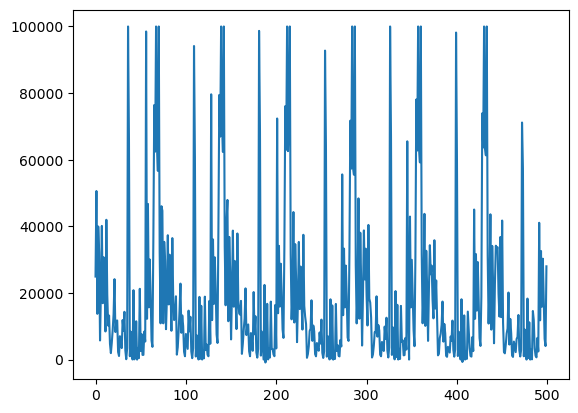

In [49]:
train_y[:500].plot()

In [50]:
train_y

0         24924.50
1         50605.27
2         13740.12
3         39954.04
4         32229.38
            ...   
421565     2487.80
421566     5203.31
421567    56017.47
421568     6817.48
421569     1076.80
Name: Weekly_Sales, Length: 421570, dtype: float64

### 1.Linear Regression

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [52]:
clf = LinearRegression()
clf.fit(train_X, train_y)
y_pred_linear=clf.predict(test_X)
acc_linear=clf.score(train_X, train_y)
print ('score: ', acc_linear )

score:  0.09098119068744615


### 2. Random Forest

In [53]:
clf = RandomForestRegressor(n_estimators=100,n_jobs= -1)
clf.fit(train_X, train_y)
y_pred_rf=clf.predict(test_X)
acc_rf= round(clf.score(train_X, train_y) * 100, 2)
print ("Accuracy: %i %% \n"%acc_rf)

Accuracy: 99 % 



### 3. Decision Tree

In [54]:
clf=DecisionTreeRegressor()
clf.fit(train_X, train_y)
y_pred_dt= clf.predict(test_X)
acc_dt = round( clf.score(train_X, train_y) * 100, 2)
print (str(acc_dt) + ' percent')

100.0 percent


### 4. XGBoost

In [55]:
clf=XGBRegressor(n_jobs= -1)
clf.fit(train_X, train_y)
y_pred_dt= clf.predict(test_X)
acc_XGB = round( clf.score(train_X, train_y) * 100, 2)
print (str(acc_XGB) + ' percent')

94.91 percent


### Comparing Models
### Let's compare the accuracy score of all the regression models used above.

In [56]:
models = pd.DataFrame({
    'Model': ['Linear Regression','Random Forest','Decision Tree', "XGBoost"],
    
    'Score': [acc_linear, acc_rf,acc_dt, acc_XGB]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
2,Decision Tree,100.000000
1,Random Forest,99.770000
3,XGBoost,94.910000
0,Linear Regression,0.090981
